# Home 3: Build a CNN for image recognition.

### Name: Sarita Hedaya


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accurcy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2019F/blob/master/homework/HM3/HM3.html


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [0]:
from keras.datasets import cifar10
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### How does the data look like?

Print a data point to see how it looks like. This will help me know if I need to rescale to 1/255

In [0]:
print(x_train[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [0]:
def to_one_hot(y, num_class=10):
    one_hot_labels = numpy.zeros((y.shape[0], num_class))
    for idx, label in enumerate(y):
      one_hot_labels[idx, label] = 1
    return one_hot_labels

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### Normalize Data

For some reason, resizing with data augmentation would completely ruin my training and validation loss.

This custom function to resize pixels did it without an issue. Im not sure resizing is necessary, but seems to be common practice. So I did it.

In [0]:
# scale pixels
def scale_pixels(train, test):
	# convert from integers to floats first
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

x_train, x_test = scale_pixels(x_train, x_test)

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [0]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))


Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

### Define the NN Architecture

**A Note on how I got here**

> This is the network architecture I arrived at after trying over 15 different approaches over a period of one week. All of my attempts are documented in a google doc. I didn't upload it because its pretty messy :p



*   Starting with the given network, and adding layers and dropout, I quickly realized that validation accuracy wouldnt go above the low 70's without data augmentation. 

*   I implemented data augmentation and tuned it a bit, since then I experienced almost no overfitting (except on a few experiments).

* I continuously increased the complexity of my model, from under 1M parameters, to well above 3M parameters, seeing no overfitting when using light dropout (0.1-0.3 for the conv layers--which I later realized was a mistake, 0.4 for the FC).

* At one point I was stuck, not being able to reach above ~81.5% validation accuracy. Given that I had experienced nearly no overfitting, and that my intuition told me that conv layer dropout made little sense, I decided to remove the dropout on the convolutional layers. 

* Seeing that my accuracy increased, I did some research and turns out Dropout in Conv layers is a bad idea.

* Below is the final model. I'm sure it can be improved with fancier architectures, but given that each epoch takes almost two minutes to train, I left it at that. 








In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation
from keras.models import Sequential
from keras.layers.core import Dropout

model = Sequential()

model.add(Conv2D(32, (7,7), padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (7,7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (7,7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2)) # is dropout useful here?

model.add(Conv2D(64, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
 
model.add(Conv2D(64, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))
 
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
 
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
 
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.1)) #see if this will help. half million params

model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.1)) #see if this will help. half million params

model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Dropout(0.1)) #see if this will help. half million params

model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))
 
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
 
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 32, 32, 32)        4736      
_________________________________________________________________
batch_normalization_127 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
activation_127 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 32, 32, 32)        50208     
_________________________________________________________________
batch_normalization_128 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
activation_128 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 32, 32, 32)       

### Compile model

In [0]:
from keras import optimizers

learning_rate = 0.001 # from 0.00001 to 0.0001: val_acc stops increasing at epoch 10 - 0.66

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9),
              metrics=['accuracy'])

### Reduce the Learning Rate during training



In [0]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, ModelCheckpoint, EarlyStopping, LearningRateScheduler

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                               cooldown=0, patience=3, min_lr=0.5e-6, verbose=1)



csv_logger = (CSVLogger("/content/log.csv"))

early_stopper = EarlyStopping(min_delta=0.001, patience=12, verbose=1)

checkpoint = ModelCheckpoint("/content/model_final.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="auto", period=5)

### Use data augmentation

The objects on CIFAR10 can be flipped horizontally and still make sense. 

They can also be rotated slightly and shifted vertically and horizontally and still make sense.

Use the ImageDataGenerator to generate samples using random combinations of these characteristics.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
                                    # rescale=1./255, 
                                    horizontal_flip = True, 
                                    rotation_range = 10, 
                                    height_shift_range = 0.05, 
                                     width_shift_range = 0.05)

image_generator.fit(x_tr)

In [0]:
history = model.fit_generator(image_generator.flow(x_tr, y_tr, batch_size=32),
                              steps_per_epoch = x_tr.shape[0] // 32,
                              epochs=70, 
                              validation_data=(x_val, y_val),
                              callbacks = [lr_reducer, csv_logger, checkpoint, early_stopper],
                              verbose=1)

Epoch 1/70
1250/1250 [==============================] - 99s 79ms/step - loss: 1.9251 - acc: 0.2754 - val_loss: 1.7446 - val_acc: 0.3403
Epoch 2/70
1250/1250 [==============================] - 94s 75ms/step - loss: 1.5945 - acc: 0.4150 - val_loss: 1.5851 - val_acc: 0.4210
Epoch 3/70
1250/1250 [==============================] - 92s 74ms/step - loss: 1.4174 - acc: 0.4862 - val_loss: 1.6172 - val_acc: 0.4351
Epoch 4/70
1250/1250 [==============================] - 92s 74ms/step - loss: 1.2806 - acc: 0.5425 - val_loss: 1.3030 - val_acc: 0.5215
Epoch 5/70
1250/1250 [==============================] - 93s 74ms/step - loss: 1.1640 - acc: 0.5846 - val_loss: 1.3671 - val_acc: 0.5200

Epoch 00005: val_loss improved from inf to 1.36706, saving model to /content/model_custom_prep_pixel_3convperlayer.hdf5
Epoch 6/70
1250/1250 [==============================] - 93s 74ms/step - loss: 1.0640 - acc: 0.6237 - val_loss: 1.3580 - val_acc: 0.5422
Epoch 7/70
1250/1250 [==============================] - 92s 74m

### Make some visualizations

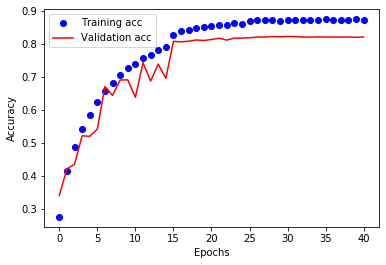

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

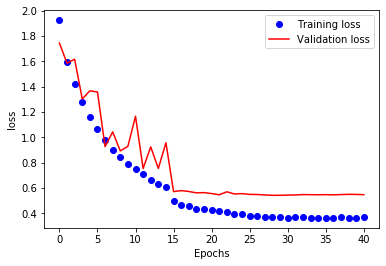

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [0]:
from keras import optimizers

learning_rate = 0.001 

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9),
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(image_generator.flow(x_train, y_train_vec, batch_size=32),
                              steps_per_epoch = x_train.shape[0] // 32,
                              epochs=35)

Epoch 1/35
 141/1562 [=>............................] - ETA: 1:45 - loss: 0.3656 - acc: 0.8732

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [59]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

10000/10000 [==============================] - 6s 612us/step
loss = 0.5192452391147614
accuracy = 0.8306
